# Modelos probabilísticos (Ejercicio)

## Aplicación de Naive Bayes multinomial a la detección de SMS *spam*

En este ejercicio se pide reproducir lo realizado en el caso práctico que se ha descrito en los vídeos (análisis de sentimiento en críticas de cine), pero ahora para detectar cuándo un mensaje corto (SMS) es *spam*.

### El conjunto de datos

El conjunto de datos consiste una serie de mensajes SMS (5574 en total), que están clasificados como mensajes basura (*spam*) o mensajes normales (*ham*). Los datos se pueden obtener en el [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). 

En concreto, descargar el fichero [smsspamcollection.zip](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip), y descomprimirlo para obtener un fichero de texto SMSSpamCollection. En este fichero de texto hay una línea por cada sms, con el formato: *clase* *tabulador* *sms*. Por ejemplo, la primera línea es:

`ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...`

El fichero debe ser leído convenientemente para poder aplicar la vectorización. Se puede hacer la lectura usando las funciones python de lectura de ficheros, pero se recomienda usar la instrucción `read_table` de la biblioteca `pandas`:

In [1]:
import pandas as pd

*Pandas* es una biblioteca de python muy utilizada para manipular y analizar datos. Si el fichero se lee con la orden `read_table` (se pide averiguar la manera concreta de hacerlo), entonces se obtendrá una tabla (o *Data Frame*), en el que las etiquetas serán una columna y los correspondientes sms otra. Esto permite obtener de manera sencilla la lista de etiquetas o clases, y por otro lado la lista de mensajes, en el mismo orden.  

### Aprendiendo a clasificar SMSs

Se pide reproducir con estos datos lo realizado en el *notebook* en el que se aplica Naive Bayes Multinomial al análisis de sentimientos de críticas de cine, pero ahora para clasificar un SMS como *spam* o como normal. Esto incluye:

* Separación de los textos en entrenamiento y prueba 
* Vectorización de los textos 
* Aprendizaje con `MultinomialNB`
* Mostrar algunas clasificaciones sobre sms concretos.
* Rendimiento sobre entrenamiento y prueba.
* Ajuste manual del parámetro de suavizado
* Vectorización con `min_df` y `stop_words` 

**Nota**: este conjunto de datos no es balanceado (la mayoría son *ham*). Por tanto, usar `score` no es muy ilustrativo del rendimiento, ya que un clasificador "tonto" que siempre predijera *ham* tendría un rendimiento alto. Por ello, en este caso también se hace necesario usar el método `confusion_matrix` del módulo `metrics`. Se pide también explicar la salida que proporciona dicha métrica.

Se pide **comentar adecuadamente cada paso realizado**, relacionándolo con lo visto en la teoría. En particular, se pide mostrar parte de los atributos `class_count_`, `class_log_prior_`, `feature_count_` y `feature_log_prob_`, explicando claramente qué son cada uno de ellos. Explicar también cómo realiza las predicciones el modelo aprendido, tal y como se ha explicado en la teoría.  



# Solución

**Autor**: Sergio Rodríguez Calvo

Antes de comenzar, vamos a importar todas las librerías y clases que vamos a necesitar.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

Para cargar los datos, vamos a utilizar `read_table` de `pandas`, indicando la ruta al fichero, indicando que el fichero no tiene cabecera para asignar el nombre de las columnas. También, indicamos el separador entre columnas, en este caso, el tabulador, y los nombres que queremos para las columnas.

Además, vamos a realizar una transformación de la columna `target`, que contiene la categría (indica que el SMS es normal o SPAM), para que sea categorica y se le asigna un entero a cada tipo (0 si el SMS es normal o 1 si es SPAM).

In [3]:
df = pd.read_table('./smsspamcollection/SMSSpamCollection', header=None, sep='\t', names = ['target','sms'])
df.target = pd.Categorical(df.target)
df['target'] = df.target.cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   int8  
 1   sms     5572 non-null   object
dtypes: int8(1), object(1)
memory usage: 49.1+ KB


En el _Dataframe_ tenemos 5.572 entradas en total. Pero, en el fichero hay 5.574 filas. Vamos a ver cuántas instancias hay de cada categoría.

In [4]:
print("Instancias de tipo normal: ", df[df['target'] == 0].count()) # ham
print("Instancias de tipo SPAM: ", df[df['target'] == 1].count()) # spam 

Instancias de tipo normal:  target    4825
sms       4825
dtype: int64
Instancias de tipo SPAM:  target    747
sms       747
dtype: int64


Hay dos instancias menos en el _Dataframe_ del tipo SMS normal respecto al fichero. Como en este caso vemos que hay bastantes más instancias para la categoría normal que para la categoría SPAM, es despreciable que existan dos instancias menos. No obstante, esto debe ser tenido en cuenta durante todo el experimento.

Vamos a comprobar si hay o no valores nulos en alguna instnacia.

In [5]:
print("Nulos encontrados: %i " %df.isnull().values.sum())

Nulos encontrados: 0 


Como no existen valores nulos, vamos a echar un vistazo a los datos que tenemos al principio y al final del _Dataframe_.

In [6]:
df.head()

,target,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.tail()

,target,sms
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...
5571,0,Rofl. Its true to its name


Vemos ejemplos de ambas categorias, los cuales pueden ser utilizados posteriormente para comprobar manualmente la clasificación del modelo una vez lo tengamos entrenado.

Vamos a separar los datos en dos conjuntos, uno para entrenamiento y otro para pruebas. Para ello, vamos a usar `train_test_split` que vimos en el ejercicio de la semana 1, indicando que queremos que el 30% de las instancias se utilicen para pruebas.

In [8]:
sms = df.sms.tolist()
target = df.target.tolist()

text_train, text_test, y_train, y_test = train_test_split(sms, target, stratify = target, test_size = 0.3)

print("Ejemplos por cada clase en conjunto de entrenamiento: {}".format(np.bincount(y_train)))
print("Ejemplos por cada clase en conjunto de prueba: {}".format(np.bincount(y_test)))

Ejemplos por cada clase en conjunto de entrenamiento: [3377  523]
Ejemplos por cada clase en conjunto de prueba: [1448  224]


Como ocurria con los datos orignales, sigue habiendo en cada conjunto más instancias de categoría normal que de categoría SPAM, pero se mantiene la misma proporción en ambos.

Necesitamos un componente que sepa convertir el texto del SMS en un vector que entienda la red bayesiana. Esta representación vectorial se va a realizar con `CountVectorizer` que sigue la estrategia de _bag of words_, es decir, el vector va a representar el número de veces que una palabra aparece en el texto del SMS. Y, dicho proceso, debe realizarse mediante un entrenamiento del vectorizador a partir de todos los textos de los SMS que aparecen, por ejemplo, en el conjunto de entrenamiento.

In [9]:
vect = CountVectorizer().fit(text_train)

Una vez entrenado el vectorizador, vamos a ver cuántas palabras forman el vocabulario.

In [10]:
print("Tamaño del vocabulario: {}".format(len(vect.vocabulary_)))

Tamaño del vocabulario: 7210


El vocabulario del vectorizador tiene un tamaño de 7.259 palabras. Por tanto, ya podemos utilizar este componente para transformar el texto de los SMS a vector de entrada de la red bayesiana (vetor numérico), tanto para entrenamiento como, posteriormente, para prueba.

In [11]:
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<3900x7210 sparse matrix of type '<class 'numpy.int64'>'
	with 51934 stored elements in Compressed Sparse Row format>


`X_train` es una matriz dispersa. Lo normal es que un vector tenga muchos componentes a 0 puesto que esas palabras del vocabulario no aparecen en la instancia en cuestión, representarlo con _arrays_ ordinarios seria muy ineficiente. 

Vamos a explorar el vocabulario del vectorizador.

In [12]:
feature_names = vect.get_feature_names_out() # get_feature_names is deprecated
print("Número de términos en el vocabulario: {}".format(len(feature_names)))
print("Primeras 20 características (términos):\n{}".format(feature_names[:20]))
print("Términos del 1010 al 1030:\n{}".format(feature_names[1010:1030]))
print("Términos cada 200 posiciones:\n{}".format(feature_names[::200]))

Número de términos en el vocabulario: 7210
Primeras 20 características (términos):
['00' '000' '000pes' '008704050406' '0089' '01223585236' '0125698789' '02'
 '0207' '02073162414' '02085076972' '021' '03' '04' '05' '050703' '06'
 '07' '07046744435' '07090298926']
Términos del 1010 al 1030:
['asked' 'askin' 'asking' 'asks' 'aslamalaikkum' 'asleep' 'asp' 'aspects'
 'ass' 'assessment' 'assistance' 'asssssholeeee' 'assume' 'asthere'
 'asthma' 'astne' 'astoundingly' 'astrology' 'asus' 'asusual']
Términos cada 200 posiciones:
['00' '09066364311' '330' '82242' 'agency' 'as' 'begins' 'bristol'
 'charge' 'computational' 'dancing' 'divorce' 'en' 'feelingood' 'ft'
 'green' 'hmv1' 'infections' 'kalisidare' 'life' 'madurai' 'missing'
 'necessary' 'omg' 'perf' 'prayers' 'rcvd' 'river' 'senrd' 'slip'
 'started' 'swimming' 'throw' 'twice' 'virtual' 'wihtuot' 'zebra']


Tenemos, como hemos comentado, 7.259 palabras en el vocabulario y mostramos algunos términos. Los términos o palabras del vocabulario están ordenadas por orden alfabético, por lo que vemos aquellos términos que forman las 20 primeras posiciones y las posiciones del 1.010 al 1.030 y, también, los términos cada 200 posiciones.

### Clasificacion textos usando Naive Bayes Multinomial

Una vez tenemos un componente que sabe transformar el texto de los SMS a vectores, podemos emplear el clasificador Naive Bayes de tipo multinomial. Este clasificador es un clasificador probabilistico, basandose en la independencia condicional entre atributos dado una clase. El tipo multinomial, se diferencia del simple (o bernoulli) por tener en cuenta el número de ocurrencias de un término en el documento (recordemos la vectorización que estamos aplicando), por lo que la ausencia de términos no influye en la clasificación. Por contra, en el modelo simple (o bernoulli) importan los valores por lo que la presencia o ausencia influye, además, no se tiene en cuenta el nñumero de ocurrencia de los términos.

In [13]:
# Regresión logística con el parámetro por defecto: alpha = 1.0
multinb=MultinomialNB().fit(X_train,y_train)

Creamos y entrenamos, al mismo tiempo, la red bayesiana multinomial.

La red bayesiana multinomial espera un parámetro alpha (o suavidad) que, en este caso, vale 1 ya que es el valor por defecto. Posteriormente, vamos a explicar mejor para qué sirve este parametro cuando pasemos a realizar ajustes manuales en él.

Tras entrenar al modelo, vamos a echar un vistazo a qué se ha aprendido:
* `multinb.class_count_`: cuántas instancias hay de cada clase.
* `multinb.class_log_prior_`: las log-probabilidades o probabilidades a priori, es decir, las proporciones de cada clase dentro del conjunto de entrenamiento. Se toma el logaritmo para evitar el problema de los número muy bajos.
* `multinb.feature_count_`: muestra cuántas ocurrencias hay de cada uno de los términos para cada clase (cada lista pertenece a una clase).
* `multinb.feature_log_prob_`: el logaritmo de las proporciones de las ocurrencias de cada término en la clase respecto a la ocurrencia de todos los términos en cada clase. Del mismo modo, cada lista pertenece a una clase.

In [14]:
print(multinb.class_count_)
print(multinb.class_log_prior_)
print(multinb.feature_count_)
print(multinb.feature_log_prob_)

[3377.  523.]
[-0.14398881 -2.00915037]
[[ 0.  0.  1. ...  1.  0.  1.]
 [ 8. 22.  0. ...  0.  1.  0.]]
[[-10.8423418  -10.8423418  -10.14919462 ... -10.14919462 -10.8423418
  -10.14919462]
 [ -7.68631534  -6.7480457   -9.88353991 ...  -9.88353991  -9.19039273
   -9.88353991]]


### Algunas clasificaciones

Para ver cómo se comporta el modelo, vamos a evaluar dos ejemplos, uno de cada clase, a ver si acierta. Las pruebas las vamos a hacer utilizando el conjunto de prueba.

Los mensajes que vamos a probar con el segundo mensaje y el tercero.

In [15]:
print("Segundo mensaje del conjunto de test: \n\n{}\n".format(text_test[1]))
print("Clasificación verdadera: {}.\n\n".format(y_test[1]))

print("Tercer mensaje del conjunto de test: \n\n{}\n".format(text_test[2]))
print("Clasificación verdadera: {}".format(y_test[2]))

Segundo mensaje del conjunto de test: 

Aight well keep me informed

Clasificación verdadera: 0.


Tercer mensaje del conjunto de test: 

Jus finished avatar nigro

Clasificación verdadera: 0


In [16]:
print("Predicción del clasificador para el segundo mensaje: {}\n".format(multinb.predict(vect.transform([text_test[1]]))[0]))

print("Predicción del clasificador para el tercer mensaje: {}".format(multinb.predict(vect.transform([text_test[2]]))[0]))

Predicción del clasificador para el segundo mensaje: 0

Predicción del clasificador para el tercer mensaje: 0


Vemos que el clasificador acierta para estos dos ejemplos, pero no tiene por qué ocurrir siempre así. Si buscamos más ejemplos veremos alguno que no clasifica bien. Esto lo vamos a analizar más adelante, ahora vamos a ver la predicción de probabilidad para ambos mensajes.

In [17]:
print("Predicción de probabilidad para el segundo mensaje: {}\n".format(multinb.predict_proba(vect.transform([text_test[1]]))[0]))

print("Predicción de probabilidad para el tercer mensaje: {}".format(multinb.predict_proba(vect.transform([text_test[2]]))[0]))

Predicción de probabilidad para el segundo mensaje: [9.99798771e-01 2.01229091e-04]

Predicción de probabilidad para el tercer mensaje: [0.9954392 0.0045608]


El método `predict_proba` trabaja con probabilidades, al pedir estas, vemos como de probable cree el modelo que es un ejemplo respecto de cada clase.

Ahora vamos a transformar el conjunto de prueba para obtener sus vectores numéricos, utilizando el vectorizador que tenemos entrenado, y a ver como evalúa el rendimiento en cada caso.

In [18]:
X_test = vect.transform(text_test)
print("Rendimiento de multinb sobre el conjunto de entrenamiento: {:.2f}".format(multinb.score(X_train,y_train)))
print("Rendimiento de multinb sobre el conjunto de test: {:.2f}".format(multinb.score(X_test,y_test)))

Rendimiento de multinb sobre el conjunto de entrenamiento: 0.99
Rendimiento de multinb sobre el conjunto de test: 0.98


Esta medida de rendimiento no es adecuada en cada caso ya que los conjuntos no están balanceados, esto es, tenemos bastantes más instancias para la clase 0 que para la clase 1. En este caso, una forma más adecuada de evaluar el modelo es mediante una matriz de confusión, donde podremos observar cuántas de cada clase las ha clasificado bien y cuantas mal.

In [19]:
y_pred = multinb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[1443,    5],
       [  22,  202]])

Aquí se muestra la matriz en bruto, vamos a mostrar la matriz de forma más clara y visual.

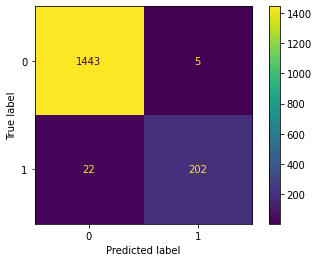

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Vamos a generar una medida del rendimiento a partir de estos datos.

In [21]:
print("Score para los mensajes normales: {:.2f}".format(cm[0,0]/(cm[0,0]+cm[0,1])))
print("Score para los mensajes SPAM: {:.2f}".format(cm[1,1]/(cm[1,1]+cm[1,0])))

Score para los mensajes normales: 1.00
Score para los mensajes SPAM: 0.90


Vemos el porcentaje de acierto en cada caso, por lo que, el modelo en este caso clasifica bien ambas clases (>90%).

### Ajuste manual de los parámetros

En este modelo, puede ocurrir un problema con las estimaciones, y es que las probabilidades pueden ser muy bajas o incluso nulas. Esto se puede deber a que no hay ejemplos en el conjunto de entrenamiento con un valor determinado para los atributos y clases. Como la probabilidad se calcula en base a un producto de probabilidades, interesa cambiar este proceso para evitar que ocurra esto (y evitar sobre ajustarse al conjunto de entrenamiento).

El parámetro `alpha` es en realidad un parámetro que permite realizar el suavizado (o suavizado de Laplace). Ahora, las estimaciones se modifican sumando ese parámetro `alpha` simulando que las estimaciones no existentes en el conjunto sí existen en el conjunto de entrenamiento.

Este proceso de ajutes de los parámetros es muy importante, ya que nos permite afinar el modelo para mejorar su rendimiento, en este caso, la herramienta `GridSearchCV` hace una validación cruzada para unos ciertos valores del parámetro alpha (en este caso) para ver cuál es valor más adecuado.

In [22]:
param_grid_nb = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 200]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
grid_nb.fit(X_train, y_train)
print("Mejor parámetro: ", grid_nb.best_params_)
print("Rendimiento de MultonomialNB en validación cruzada, con el mejor parámetro: {:.2f}".format(grid_nb.best_score_))

Mejor parámetro:  {'alpha': 0.01}
Rendimiento de MultonomialNB en validación cruzada, con el mejor parámetro: 0.98


Vemos como el parámetro `alpha` = 0.01 es más adecuado en este caso que el parámetro elegido por defecto (`alpha` = 1), por lo que conviene realizar estos cambios para mejorar el rendimiento.

#### Experimento con alpha = 10

Independientemente del resultado, vamos a probar con un par de valores de `alpha`, uno superior y otro inferior al utilizado previamente para ver qué cambia. En este caso, vamos a probar con `alpha` = 10. Como vamos a seguir los mismos pasos que anteriormente, vamos a omitir los comentarios salvo allí donde se observen diferencias que merezcan la pena comentar.

In [23]:
multinb_alpha=MultinomialNB(alpha=10).fit(X_train,y_train)
print("Rendimiento de multinb sobre el conjunto de entrenamiento {:.2f}".format(multinb_alpha.score(X_train,y_train)))
print("Rendimiento de multinb sobre el conjunto de test: {:.2f}".format(multinb_alpha.score(X_test,y_test)))

Rendimiento de multinb sobre el conjunto de entrenamiento 0.96
Rendimiento de multinb sobre el conjunto de test: 0.95


In [24]:
print(multinb_alpha.class_count_)
print(multinb_alpha.class_log_prior_)
print(multinb_alpha.feature_count_)
print(multinb_alpha.feature_log_prob_)

[3377.  523.]
[-0.14398881 -2.00915037]
[[ 0.  0.  1. ...  1.  0.  1.]
 [ 8. 22.  0. ...  0.  1.  0.]]
[[-9.35902758 -9.35902758 -9.2637174  ... -9.2637174  -9.35902758
  -9.2637174 ]
 [-8.45407588 -7.87871174 -9.04186255 ... -9.04186255 -8.94655237
  -9.04186255]]


In [25]:
y_pred = multinb_alpha.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[1447,    1],
       [  77,  147]])

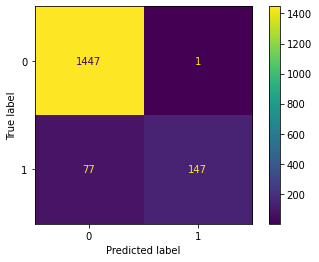

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [27]:
print("Score para los mensajes normales: {:.2f}".format(cm[0,0]/(cm[0,0]+cm[0,1])))
print("Score para los mensajes SPAM: {:.2f}".format(cm[1,1]/(cm[1,1]+cm[1,0])))

Score para los mensajes normales: 1.00
Score para los mensajes SPAM: 0.66


Vemos como para la clase 1 o SPAM, el clasificador ha reducido bastante su porcentaje de acierto para el conjunto de prueba. Sin embargo, utilizando la función `score` el porcentaje de acierto era superior al 90%. Esta diferencia entre `score` y la matriz de confusión es, como se ha explicado antes, debido a que el conjunto de datos no está balanceado.

#### Experimento con alpha = 0.1

Vamos a probar ahora con un valor de `alpha` de 0.1 Como vamos a seguir los mismos pasos que anteriormente, vamos a omitir los comentarios salvo allí donde se observen diferencias que merezcan la pena comentar.

In [28]:
multinb_alpha=MultinomialNB(alpha=0.1).fit(X_train,y_train)
print("Rendimiento de multinb sobre el conjunto de entrenamiento {:.2f}".format(multinb_alpha.score(X_train,y_train)))
print("Rendimiento de multinb sobre el conjunto de test: {:.2f}".format(multinb_alpha.score(X_test,y_test)))

Rendimiento de multinb sobre el conjunto de entrenamiento 1.00
Rendimiento de multinb sobre el conjunto de test: 0.99


In [29]:
print(multinb_alpha.class_count_)
print(multinb_alpha.class_log_prior_)
print(multinb_alpha.feature_count_)
print(multinb_alpha.feature_log_prob_)

[3377.  523.]
[-0.14398881 -2.00915037]
[[ 0.  0.  1. ...  1.  0.  1.]
 [ 8. 22.  0. ...  0.  1.  0.]]
[[-13.00923947 -13.00923947 -10.6113442  ... -10.6113442  -13.00923947
  -10.6113442 ]
 [ -7.38972408  -6.38601053 -11.78417323 ... -11.78417323  -9.38627796
  -11.78417323]]


In [30]:
y_pred = multinb_alpha.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[1441,    7],
       [  16,  208]])

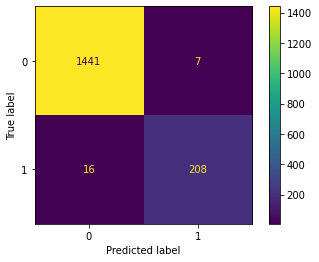

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [32]:
print("Score para los mensajes normales: {:.2f}".format(cm[0,0]/(cm[0,0]+cm[0,1])))
print("Score para los mensajes SPAM: {:.2f}".format(cm[1,1]/(cm[1,1]+cm[1,0])))

Score para los mensajes normales: 1.00
Score para los mensajes SPAM: 0.93


En este caso, el parámetro `alpha` = 0.1 es más apropiado, ya que es más cercano a 0.01, que hemos visto en la validación cruzada.

### Mejorando la vectorización: *stop words*, `min_df`

La vectorización no necesita recopilar todos los términos que aparecen en los documentos, para ello se eliminan las _stop words_ que son palabras frecuentes y que no aportan valor (preposiciones, entre otras) y, también, `min_df` que permite elminar aquellos términos que aparecen en muy pocos documentos. Vamos a emplear ambos y a reducir el vocabulario del vectorizador para mejorar el rendimiento y mejorar la precisión del modelo.

In [33]:
vect2 = CountVectorizer(min_df=3, stop_words='english').fit(text_train)
X2_train = vect2.transform(text_train)

In [34]:
print("Número de términos en el vocabulario original: {}".format(len(vect.get_feature_names_out())))
feature_names2 = vect2.get_feature_names_out()
print("Número de términos en el vocabulario con stop words y min_df: {}".format(len(feature_names2)))

Número de términos en el vocabulario original: 7210
Número de términos en el vocabulario con stop words y min_df: 1976


Hemos reducido aproximádamente en 5.000 términos el vocabulario del vectorizador, para ver qué obtenemos en este nuevo experimento.

In [35]:
multinb2=MultinomialNB().fit(X2_train,y_train)

In [36]:
print(multinb2.class_count_)
print(multinb2.class_log_prior_)
print(multinb2.feature_count_)
print(multinb2.feature_log_prob_)

[3377.  523.]
[-0.14398881 -2.00915037]
[[ 0.  0.  0. ...  4. 33.  0.]
 [ 8. 22.  7. ...  0.  0.  3.]]
[[-9.94817407 -9.94817407 -9.94817407 ... -8.33873616 -6.42181355
  -9.94817407]
 [-6.87844089 -5.94017125 -6.99622393 ... -9.07566547 -9.07566547
  -7.68937111]]


In [37]:
X2_test = vect2.transform(text_test)

print("Rendimiento de multinb2 sobre el conjunto de entrenamiento {:.2f}".format(multinb2.score(X2_train,y_train)))
print("Rendimiento de multinb2 sobre el conjunto de test: {:.2f}".format(multinb2.score(X2_test,y_test)))

Rendimiento de multinb2 sobre el conjunto de entrenamiento 0.99
Rendimiento de multinb2 sobre el conjunto de test: 0.98


Como hemos visto, esta no es la forma más adecuada de medir el rendimiento, por lo que vamos a hacer lo mismo que en el resto de experimentos, usar la matriz de confusión.

In [38]:
y_pred = multinb2.predict(X2_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[1435,   13],
       [  19,  205]])

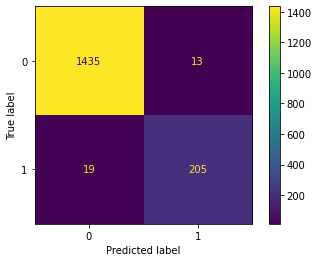

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [40]:
print("Score para los mensajes normales: {:.2f}".format(cm[0,0]/(cm[0,0]+cm[0,1])))
print("Score para los mensajes SPAM: {:.2f}".format(cm[1,1]/(cm[1,1]+cm[1,0])))

Score para los mensajes normales: 0.99
Score para los mensajes SPAM: 0.92


En este caso, vemos como el rendimiento permanece igual que en experimentos anteriores (con `alpha` mejor ajustado), ya que en este caso, reducir el vocabulario permite mejorar el rendimiento (se trabaja con menos información) pero no el rendimiento del modelo.

## Conclusion

El modelo busca similitudes a partir de lo aprendido. En este caso, se trata de un modelo probabilistico, por lo que vamos a tener una medida del grado de creencia respecto a una clasificación.

En este experimento, el modelo da un grado de creencia en base a dos clases de SMS: normal (clasificando con valor numérico 0) o SPAM (clasificado con valor numérico 1).

Para ello, vectorizamos teniendo en cuenta cuántas veces aparece un términmo (o palabra) en el mensaje, por lo que el modelo va a encontrar la relación entre ciertos términos y el número de ocurrencias de estos, para realizar la clasificación en base a una probabilidad o grado de creencia.